# Introduction
We go over the basic functionality of the code by initializing a detector and creating some time-ordered data. 

We start by importing the `ScanStrategy`, `Instrument` and `Beam` classes from `beamconv`. We we will also need some functions from `healpy`.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
fontsize=14
matplotlib.rcParams.update({'font.size':fontsize})
matplotlib.rcParams.update({'xtick.labelsize':fontsize})
matplotlib.rcParams.update({'ytick.labelsize':fontsize})
matplotlib.rcParams.update({'axes.labelsize':fontsize})
matplotlib.rcParams.update({'lines.markersize': 4})

import numpy as np
import healpy as hp
from beamconv import ScanStrategy
from beamconv import Instrument
from beamconv import Beam
from beamconv import tools

For simplicity we will only use a single detector in this example. Detectors are represented by instances of the `Beam` class we just imported. A `Beam` instance contains detector properties such as pointing offsets, but also pointers to the harmonic modes of the actual beam.

First lets see what options we are allowed to set set for our `Beam` instance:

In [2]:
?Beam()

Let's create a detector without pointing offset (i.e. with beam centre on the telescope's boresight). For now we simply take a Gaussian beam model. We can thus fully specify the beam with the `fwhm` (Full Width at Half Maximum) parameter. Here we pick `fwhm=40`, in units of arcmin. Since the 2D Gaussian is azimuthally symmetric, we may set the `symmetric` option.

In [3]:
beam_opts = dict(az=0, 
                 el=0,
                 polang=0,
                 fwhm=40,
                 btype='Gaussian', 
                 lmax=800,
                 symmetric=True)
beam = Beam(**beam_opts)
print beam

name   : None 
btype  : Gaussian 
alive  : True 
FWHM   : 40 arcmin 
az     : 0 deg 
el     : 0 deg 
polang : 0.0 deg



In order to start simulating data we need to initialize a `ScanStrategy` instance that manages the simulated data-taking. `ScanStrategy` inherents from the `Instrument` class, so by initializing it we also initialize an `Instrument` instance. Let's see what both classes need as input:

In [4]:
?Instrument()

In [5]:
?ScanStrategy()

For simplicity we pick a preset location for the instrument (the south pole). For the scan strategy we mostly leave the defaults but specify that we would like to simulate one hour of data at a 100 Hz sample rate.

In [6]:
instr_opts = dict(location='spole')
scan_opts = dict(duration=3600,
                 sample_rate=100)
scan_opts.update(instr_opts)

S = ScanStrategy(**scan_opts)

Lets add our beam to the detectors focal plane. Each `Instrument` instance has a `beams` attribute: a list of detector pairs that represent the focal plane. Because we only have a single detector, our detector will have a empty slot as detector partner.

In [7]:
S.add_to_focal_plane(beam)
print(S.beams)

[[<beamconv.detector.Beam object at 0x1138a2110>, None]]


We now specify the telescope's pointing (the boresight pointing). For this example we use a preset scan strategy: a constant-elevation scanning pattern. To do so, we use the `constant_el_scan()` method of our `ScanStrategy` instance. Lets see what input we need to provide:

In [8]:
?S.constant_el_scan()

We leave the scan centre set to its default value (`ra0`, `dec0` = -10, -57.5, which is always visible from the south pole) and set the angular speed and azimuthal width of the scans.

In [9]:
const_el_opts = dict(az_throw=50.,
                     scan_speed=10.)                 

We also need to specify the input sky. We do this by providing the harmonic coefficients of the sky in a tuple containing unpolarized and E-, B-modes: ($a_{\ell m}$, $a_{E, \ell m}, a_{B, \ell m}$). Here we use the coefficients of a Gaussian sky with covariance given by some best-fit WMAP $\Lambda$CDM power spectrum.

In [10]:
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
_, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=800, new=True, verbose=False) # uK

The actual scanning of the sky can be done by using the `scan_instrument_mpi` method of `ScanStrategy`. Broadly speaking, this function first calls the `init_spinmaps` function that performs the inverse spherical harmonic transforms needed for the beam convolution, then it calls the `constant_el_scan` function we mentioned above to populate the boresight pointing quaternions. Finally, it calls the `scan` function that combines boresight pointing, detector pointing and the beam-convolved maps to calculate the final time-ordered data. 

Note that `scan_instrument_mpi` will also work with more than one detector on the focal plane, possibly distributing the workload over available MPI ranks. 

For this demonstration, we can separate the inverse spherical harmonic transforms and the scanning. To do so, we first call the `init_detpair` function. This will populate the beam-convolved `spinmaps`. If we then call  `scan_instrument_mpi` with `reuse_spinmaps=True` it will use the precomputed `spinmaps`.

In [11]:
beam = S.beams[0][0]
S.init_detpair(alm, beam, beam_b=None, nside_spin=512, verbose=False)

Then we do the actual scanning of the sky. We set the `save_tod` option to save the data we are about to generate. 

In [12]:
S.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=True, interp=False, save_tod=True, **const_el_opts)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


We can extract the data we just generated by calling the `data` method. Data sampling is generally done in periods of time that divide up the full mission in to managable "chunks" of data. In our case we have only used one chunk. The chunks are stokes in the `chunks` attribute.

In [13]:
print('No. of chunks used: {}'.format(len(S.chunks)))
chunk = S.chunks[0]
print(chunk)
tod = S.data(chunk, beam=beam, data_type='tod')

No. of chunks used: 1
{'cidx': 0, 'start': 0, 'end': 360000}


Lets plot the first 500 data points:

Text(0,0.5,u'Signal [$\\mu K_{\\mathrm{CMB}}$]')

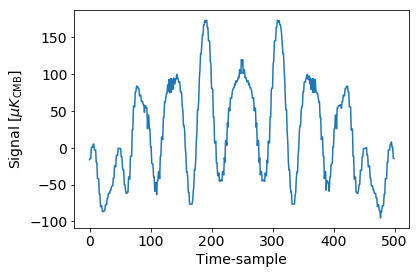

In [14]:
fig, ax = plt.subplots()
ax.plot(tod[:500])
ax.set_xlabel('Time-sample')
ax.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')

We can rerun with the `interp` option set to use bi-linear interpolation while sampling the beam-convolved maps.

In [15]:
S.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=True, interp=True, save_tod=True, **const_el_opts)
tod_interp = S.data(S.chunks[0], beam=beam, data_type='tod')

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


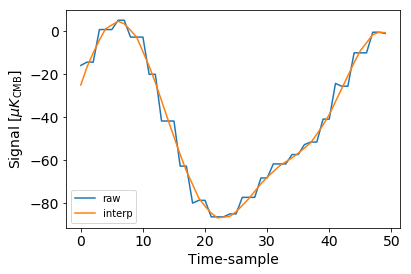

In [16]:
fig, ax = plt.subplots()
ax.plot(tod[:50], label='raw')
ax.plot(tod_interp[:50], label='interp')
ax.set_xlabel('Time-sample')
ax.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax.legend()

# Temperature-to-Polarization leakage

With the basic structure of the code set, we take a look at a leading-order optical systematic: temperature-to-polarization leakage due to azimuthally asymmetric beams.

In this example we use precomputed harmonic modes for a beam from a simple 2-lens refracting telescope.  As this beam is not azimuthally symmetric, we have to specify the number of azimuthal modes we consider. As we will see, the beam is only weakly asymmetric so we only use the first 5 modes by setting `mmax = 5`. The equivalent Gaussian beamwidth is roughly 38 arcmin.

In [17]:
beam_dir = '../tests/test_data/example_blms/'
beam_opts = dict(az=0, 
                 el=0,
                 polang=0,
                 fwhm=38,
                 btype='PO', # Physical optics.
                 lmax=800,
                 mmax=5,
                 po_file=beam_dir+'blm_hp_X1T1R1C8A_800_800.npy')
beam2 = Beam(**beam_opts)

Lets take a look at the beam and compare it to the Gaussian approximation. First, lets plot the two intensity beams:

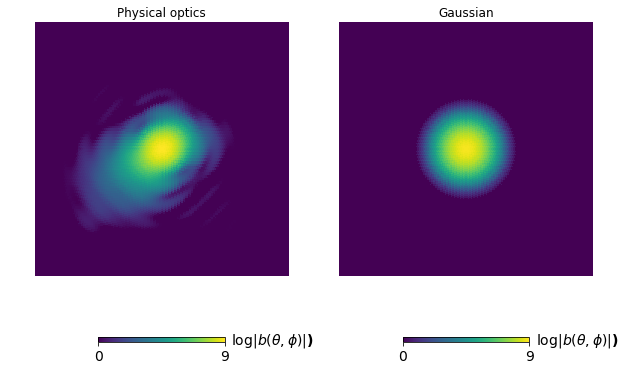

In [18]:
def blm2bmap(beam, nside=1024):
    '''
    Compute pixelized map of the intensity beam of 
    Beam instance.
    
    Arguments
    ---------
    beam : <beamconv.detector.Beam>
    
    Keyword arguments
    -----------------
    nside : int
        Nside of output maps
        
    Returns
    -------
    beammaps : array-like
        HEALPix map of intensity beam.        
    '''
    blm = np.asarray(beam.blm).copy()[0]
    # We need to divide out sqrt(4pi / (2 ell + 1)) to get 
    # correctly normlized spherical harmonic coeffients.
    ell = np.arange(hp.Alm.getlmax(blm.size))
    q_ell = np.sqrt(4. * np.pi / (2 * ell + 1))
    blm = hp.almxfl(blm, 1 / q_ell)
    return hp.alm2map(blm, nside, verbose=False)

beam2.btype='PO'
bmap_po = blm2bmap(beam2)
del(beam2.blm)
beam2.btype='Gaussian'
bmap_ga = blm2bmap(beam2)
del(beam2.blm)

cart_opts = dict(rot=[0, 90, 0], lonra=[-3,3], latra=[-3,3], min=0, max=9,
                 hold=True, unit=r'$\log |b(\theta, \phi)|$)')

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 14))
plt.axes(axs[0])
hp.cartview(np.log(np.abs(bmap_po)), title="Physical optics", **cart_opts)
plt.axes(axs[1])
hp.cartview(np.log(np.abs(bmap_ga)), title="Gaussian", **cart_opts) 



It is also instructive to compare the harmonic modes. First we take a look at the $m=0$ modes (the azimuthally symmetric components). We see that the physical optics beams are slightly non-Gaussian. Note that we plot spherical harmonic modes that are normalized at the monopole by defining $q_{\ell} = \sqrt{\frac{4 \pi}{(2\ell +  1)}}$.

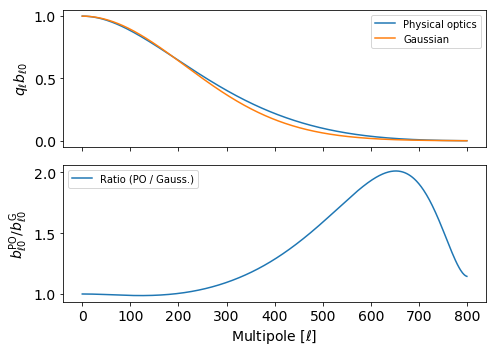

In [19]:
beam2.btype='PO'
bell_po = np.real(tools.blm2bl(beam2.blm[0]))
del(beam2.blm)
beam2.btype='Gaussian'
bell_ga = np.real(tools.blm2bl(beam2.blm[0]))
del(beam2.blm)

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(7, 5), sharex=True)
axs[0].plot(bell_po, label='Physical optics')
axs[0].plot(bell_ga, label='Gaussian')
axs[1].plot(bell_po / bell_ga, label='Ratio (PO / Gauss.)')
axs[0].set_ylabel(r'$q_{\ell} b_{\ell 0}$')
axs[1].set_ylabel(r'$b^{\mathrm{PO}}_{\ell 0} / b^{\mathrm{G}}_{\ell 0}$')
axs[1].set_xlabel(r'Multipole [$\ell$]')
axs[0].legend()
axs[1].legend()
fig.tight_layout()

Now we take a look at the azimuthally asymmetric modes of the physical optics beam. It is clear that most information is stored in the low $m$ modes and that even the largest asymetric components have only few percent of the symmetric component's amplitude. Note that the $m\neq0$ modes are complex numbers so we plot the real and imaginary part.

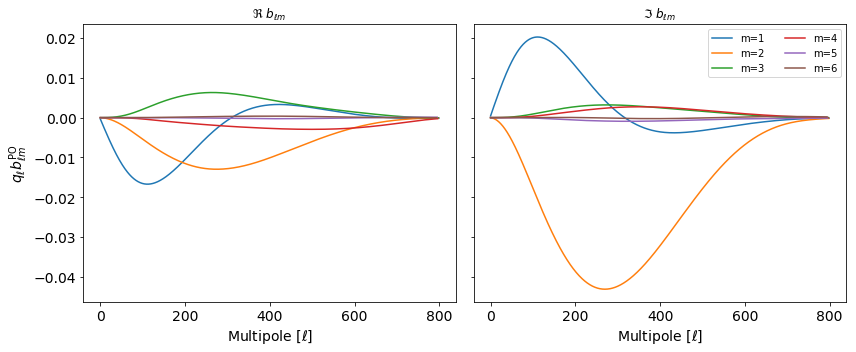

In [20]:
beam2.btype='PO'
blm = beam2.blm[0]
del(beam2.blm)
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
for m in range(1,7):
    bell = tools.blm2bl(blm, m=m)
    axs[0].plot(np.real(bell), label='m={}'.format(m))
    axs[1].plot(np.imag(bell), label='m={}'.format(m))
axs[1].legend(ncol=2)
axs[0].set_title(r'$\Re \ b_{\ell m}$')
axs[1].set_title(r'$\Im \ b_{\ell m}$')
axs[0].set_ylabel(r'$q_{\ell} b^{\mathrm{PO}}_{\ell m}$')
axs[0].set_xlabel(r'Multipole [$\ell$]')
axs[1].set_xlabel(r'Multipole [$\ell$]')
fig.tight_layout()

We initiate a new `ScanStrategy` instance and add our new beam.

In [21]:
S2 = ScanStrategy(**scan_opts)
S2.add_to_focal_plane(beam2)

This time we let the instrument rotate 36 degrees around the boresight every 100 seconds in addition the to constant-elevation scanning

In [22]:
S2.set_instr_rot(period=100, angles=np.linspace(0, 360, 10))

We turn off the linearly polarized component of the sky. This means that any sign of a polarized signal in the data will be due to systematic effects.

In [23]:
alm = np.asarray(alm)
alm[1] *= 0
alm[2] *= 0

Let us start by scanning the sky with the Gaussian beam. This time we also save the indices of the pixels visited by the scan strategy and the position angle `pa` (or $\psi$) at each sample.

In [24]:
S2.set_btypes('Gaussian')
beam2.symmetric = True
S2.reset_instr_rot()
S2.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=False, interp=False, 
                       save_point=True, save_tod=True, nside_spin=512, **const_el_opts)
pix_ga = S2.data(S2.chunks[0], beam=beam2, data_type='pix')
pa_ga = S2.data(S2.chunks[0], beam=beam2, data_type='pa')
tod_ga = S2.data(S2.chunks[0], beam=beam2, data_type='tod')

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


Lets now plot the data gathered from a single pixel on the sky. We pick the pixels that is most visited by the scanning. If we now plot the signal gathered from this pixel, we expect no variation with position angle. This is because the Gaussian beam is azimuthally symmetric. So despite the rotation of the boresight every 100 seconds, the signal should remain constant.

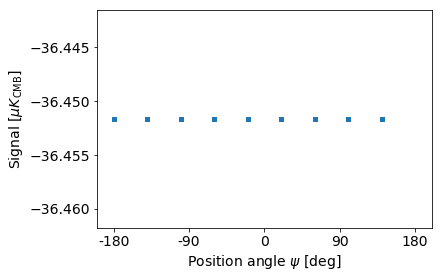

In [25]:
common_pix_ga = np.bincount(pix_ga).argmax()
fig, ax = plt.subplots()
ax.scatter(pa_ga[pix_ga==common_pix_ga], tod_ga[pix_ga==common_pix_ga])
ax.set_xlim(-200, 200)
_= ax.set_xticks([-180, -90, 0, 90, 180])
_= ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_xlabel(r"Position angle $\psi$ [$\deg$]")
_= ax.set_ylabel(r"Signal [$\mu K_{\mathrm{CMB}}$]")

Lets now repeat the scanning, but with the physical optics beam. This time, the (internal) call to `init_detpair` will take longer as the code also has to perform inverse spherical harmonic transforms for all of the $m \neq 0$ modes of the intensity beam (and all the $m \neq 2$ modes of the linearly polarized beam).

In [26]:
S2.set_btypes('PO')
beam2.symmetric = False
S2.reset_instr_rot()
S2.scan_instrument_mpi(alm, binning=False, reuse_spinmaps=False, interp=False, 
                       save_point=True, save_tod=True, nside_spin=512, **const_el_opts)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-360000


Lets plot the signal in the most visited pixel as function of position angle again. This time we see a variation with position angle. Remember that there is no linearly polarized component to the input sky in this simulation. All the variation is thus because of the asymmetry of the beam. 

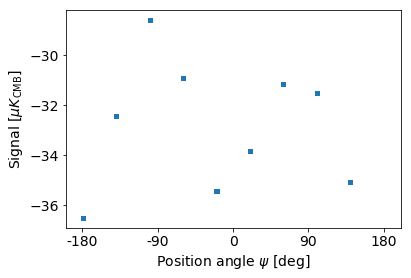

In [27]:
pix_po = S2.data(S2.chunks[0], beam=beam2, data_type='pix')
pa_po = S2.data(S2.chunks[0], beam=beam2, data_type='pa')
tod_po = S2.data(S2.chunks[0], beam=beam2, data_type='tod')

common_pix_po = np.bincount(pix_po).argmax()
fig, ax = plt.subplots()
ax.scatter(pa_po[pix_po==common_pix_po], tod_po[pix_po==common_pix_po])
ax.set_xlim(-200, 200)
_= ax.set_xticks([-180, -90, 0, 90, 180])
_= ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_xlabel(r"Position angle $\psi$ [$\deg$]")
_= ax.set_ylabel(r"Signal [$\mu K_{\mathrm{CMB}}$]")

The above plot demonstrates the systematic temperature-to-polarization leakage we care about in this example. The point is that a linearly polarized sky signal will produce a sinusoidal signature with period $2 \psi$ in a plot like the above. We see that the signal in this pixel shows this behaviour (plus some other harmonics). A map-making algorithm that uses the time-ordered data and angular information to reconstruct the linearly polarized sky signal will therefore wronly interpret the above as polarized signal.